In [44]:
import pystac_client
from odc import stac as odc_stac
from dask.distributed import wait
from dask.distributed import Client, wait
import os
import xarray as xr
import pyproj
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import rioxarray
import hvplot.xarray

### Load the data

In [2]:
# set up dask client for paralelized computation
client = Client(processes=False, threads_per_worker=2, n_workers=3, memory_limit="12GB")

# Connect to STAC catalog
eodc_catalog = pystac_client.Client.open("https://stac.eodc.eu/api/v1/")

2025-10-16 22:35:34,563 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 8.11 GiB -- Worker memory limit: 11.18 GiB


In [5]:
# we define the time range of the event and coordinates of the area with the bounding_box
time_range = "2018-02-28/2018-02-28"
minlon, maxlon = 22.0, 22.8  
minlat, maxlat = 39.45, 39.75

bounding_box = [minlon, minlat, maxlon, maxlat]

In [6]:
# inside the EODC catalogue we get the GFM collection (Global Flood Monitoring) https://services.eodc.eu/browser/#/v1/collections/GFM?.language=en
search = eodc_catalog.search(collections="GFM", bbox=bounding_box, datetime=time_range)
items_GFM = search.item_collection()

items_GFM[0].properties

{'gsd': 20,
 'created': '2024-10-29T13:09:01.227757+00:00',
 'datetime': '2018-02-28T16:32:02Z',
 'Equi7Tile': 'EU020M_E054N006T3',
 'blocksize': {'x': 512, 'y': 512},
 'proj:bbox': [5400000, 600000, 5700000, 900000],
 'proj:wkt2': 'PROJCS["Azimuthal_Equidistant",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["latitude_of_center",53],PARAMETER["longitude_of_center",24],PARAMETER["false_easting",5837287.81977],PARAMETER["false_northing",2121415.69617],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]',
 'proj:shape': [15000, 15000],
 'constellation': 'sentinel-1',
 'flood_members': {'DLR': True, 'TUW': True, 'LIST': True},
 'proj:geometry': {'type': 'Polygon',
  'coordinates': [[[5400000.0, 600000.0],
    [5400000.0, 900000.0],
    [5700000.0, 900000.0],
    [5700000.0, 600000.0],
    [540000

In [7]:
crs = pyproj.CRS.from_wkt(items_GFM[0].properties["proj:wkt2"])

# Set the resolution of the data
resolution = items_GFM[0].properties['gsd']

GFM_dc= odc_stac.load(
    items_GFM, 
    bbox=bounding_box,   # Define the bounding box for the area of interest
    crs=crs,   # Set the coordinate reference system
    #bands=["tuw_likelihood","tuw_flood_extent"],   # Specify the bands to load, comment to load all bands
    resolution=resolution,   # Set the resolution of the data
    dtype='uint8',   # Define the data type
    chunks={"x": 1000, "y": 1000, "time": -1},  # Set the chunk size for Dask
)

GFM_dc = GFM_dc.persist()
wait(GFM_dc)


DoneAndNotDoneFutures(done={<Future: finished, type: numpy.ndarray, key: ('dlr_likelihood-05f5cee9c8e3c417df4ee6afaaeed843', 0, 1, 1)>, <Future: finished, type: numpy.ndarray, key: ('dlr_likelihood-05f5cee9c8e3c417df4ee6afaaeed843', 0, 0, 3)>, <Future: finished, type: numpy.ndarray, key: ('ensemble_flood_extent-05f5cee9c8e3c417df4ee6afaaeed843', 0, 0, 2)>, <Future: finished, type: numpy.ndarray, key: ('tuw_likelihood-05f5cee9c8e3c417df4ee6afaaeed843', 0, 1, 0)>, <Future: finished, type: numpy.ndarray, key: ('ensemble_water_extent-05f5cee9c8e3c417df4ee6afaaeed843', 0, 1, 1)>, <Future: finished, type: numpy.ndarray, key: ('tuw_flood_extent-05f5cee9c8e3c417df4ee6afaaeed843', 0, 0, 0)>, <Future: finished, type: numpy.ndarray, key: ('dlr_flood_extent-05f5cee9c8e3c417df4ee6afaaeed843', 0, 1, 0)>, <Future: finished, type: numpy.ndarray, key: ('tuw_flood_extent-05f5cee9c8e3c417df4ee6afaaeed843', 0, 0, 2)>, <Future: finished, type: numpy.ndarray, key: ('dlr_flood_extent-05f5cee9c8e3c417df4ee6af

In [8]:
# Pre-processing
# Substitute 255 for NaNs
GFM_dc["tuw_flood_extent"] = GFM_dc.tuw_flood_extent.where(GFM_dc.tuw_flood_extent!=255).compute()
GFM_dc["tuw_likelihood"] = GFM_dc.tuw_likelihood.where(GFM_dc.tuw_likelihood!=255).compute()
GFM_dc["reference_water_mask"] = GFM_dc.reference_water_mask.where(GFM_dc.reference_water_mask!=255).compute()
GFM_dc["exclusion_mask"] = GFM_dc.exclusion_mask.where(GFM_dc.exclusion_mask!=255).compute()

In [9]:
# Access the variables
tuw_likelihood = GFM_dc["tuw_likelihood"]
tuw_flood_extent = GFM_dc["tuw_flood_extent"]

tuw_likelihood = tuw_likelihood.isel(time=1)
tuw_flood_extent = tuw_flood_extent.isel(time=1)
reference_water_mask = GFM_dc["reference_water_mask"].isel(time=1)
exclusion_mask = GFM_dc["exclusion_mask"].isel(time=1)

In [10]:
tuw_flood_extent

<xarray.DataArray 'tuw_flood_extent' (y: 1739, x: 3500)> Size: 24MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(1739, 3500), dtype=float32)
Coordinates:
  * y            (y) float64 14kB 6.508e+05 6.508e+05 ... 6.161e+05 6.161e+05
  * x            (x) float64 28kB 5.664e+06 5.664e+06 ... 5.734e+06 5.734e+06
    spatial_ref  int32 4B 27704
    time         datetime64[ns] 8B 2018-02-28T04:39:08
Attributes:
    nodata:   255

In [11]:
crs = tuw_flood_extent.rio.crs
ae_crs  =crs.to_proj4()


In [12]:
da = tuw_flood_extent.rio.write_crs(ae_crs)

# Step 4: Reproject to WGS84 (lon/lat)
da_ll = da.rio.reproject("EPSG:4326")

# Step 5: Clip to your bounding box
minlon, maxlon = 22.0, 22.8
minlat, maxlat = 39.45, 39.75
da_ll_clipped = da_ll.rio.clip_box(minx=minlon, maxx=maxlon, miny=minlat, maxy=maxlat)

 

da_visible = da_ll_clipped.where(da_ll_clipped == 1)
da_visible.hvplot.image(
    x="x", y="y",
    geo=True,
    tiles="OSM",
    cmap=["darkred"],
    alpha=0.75,
    frame_height=450,
    title="Flood Extent on Map",
    colorbar=False
)

:Overlay
   .WMTS.I  :WMTS   [Longitude,Latitude]
   .Image.I :Image   [x,y]   (tuw_flood_extent)

### Pakistan

In [13]:
from dcloader import DcLoader

time_range_pakistan = '2022-09-23T01:25:51Z/2022-09-23T01:25:52Z'
bounding_box_pakistan = [67.9, 27.0, 68.7, 27.8]

dc_loader = DcLoader(eodc_catalog)
pakistan_dc = dc_loader.load_GFM_data(time_range_pakistan, bounding_box_pakistan)

Persisting data cube to Dask cluster...
Data loaded successfully.


In [14]:
# Pre-processing
# Substitute 255 for NaNs
pakistan_dc["tuw_flood_extent"] = pakistan_dc.tuw_flood_extent.where(pakistan_dc.tuw_flood_extent!=255).compute()
pakistan_dc["tuw_likelihood"] = pakistan_dc.tuw_likelihood.where(pakistan_dc.tuw_likelihood!=255).compute()
pakistan_dc["reference_water_mask"] = pakistan_dc.reference_water_mask.where(pakistan_dc.reference_water_mask!=255).compute()
pakistan_dc["exclusion_mask"] = pakistan_dc.exclusion_mask.where(pakistan_dc.exclusion_mask!=255).compute()

In [15]:
pakistan_tuw_flood_extent = pakistan_dc["tuw_flood_extent"]


In [16]:
crs = pakistan_tuw_flood_extent.rio.crs
ae_crs  =crs.to_proj4()
pakistan_tuw_flood_extent = pakistan_tuw_flood_extent.rio.write_crs(ae_crs)

In [17]:
#Reproject to WGS84 (lon/lat)
pakistan_ll = pakistan_tuw_flood_extent.rio.reproject("EPSG:4326")

#Clip to your bounding box
minlon, maxlon = 67.9, 68.7
minlat, maxlat = 27.0, 27.8
pakistan_ll_clipped = pakistan_ll.rio.clip_box(minx=minlon, maxx=maxlon, miny=minlat, maxy=maxlat)

In [18]:

pakistan_visible = pakistan_ll_clipped.where(pakistan_ll_clipped == 1)

pakistan_visible.hvplot.image(
    x="x", y="y",
    geo=True,
    tiles="OSM",
    cmap=["darkred"],
    alpha=0.75,
    frame_height=450,
    title="Flood Extent on Map",
    colorbar=False
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'0d365de5-990a-4b77-a484-0827d0f9b3cc': {'version…

### Germany

In [33]:
# we define the time range of the event and coordinates of the area with the bounding_box
time_range = "2023-10-11/2023-10-25"
minlon, maxlon = 12.3, 13.1
minlat, maxlat = 54.3, 54.6
bounding_box = [minlon, minlat, maxlon, maxlat]

In [34]:
# inside the EODC catalogue we get the GFM collection (Global Flood Monitoring) https://services.eodc.eu/browser/#/v1/collections/GFM?.language=en
search = eodc_catalog.search(collections="GFM", bbox=bounding_box, datetime=time_range)
items_GFM = search.item_collection()

print(f"Found {len(items_GFM)} items") 

Found 37 items


In [35]:
crs = pyproj.CRS.from_wkt(items_GFM[0].properties["proj:wkt2"])

# Set the resolution of the data
resolution = items_GFM[0].properties['gsd']

german_dc= odc_stac.load(
    items_GFM, 
    bbox=bounding_box,   # Define the bounding box for the area of interest
    crs=crs,   # Set the coordinate reference system
    #bands=["tuw_likelihood","tuw_flood_extent"],   # Specify the bands to load, comment to load all bands
    resolution=resolution,   # Set the resolution of the data
    dtype='uint8',   # Define the data type
    chunks={"x": 1000, "y": 1000, "time": -1},  # Set the chunk size for Dask
)

german_dc = german_dc.persist()
wait(german_dc)

german_dc

<xarray.Dataset> Size: 2GB
Dimensions:                (y: 2064, x: 2829, time: 28)
Coordinates:
  * y                      (y) float64 17kB 2.362e+06 2.362e+06 ... 2.32e+06
  * x                      (x) float64 23kB 5.079e+06 5.079e+06 ... 5.136e+06
  * time                   (time) datetime64[ns] 224B 2023-10-11T05:33:18 ......
    spatial_ref            int32 4B 27704
Data variables:
    advisory_flags         (time, y, x) uint8 163MB dask.array<chunksize=(28, 1000, 1000), meta=np.ndarray>
    dlr_likelihood         (time, y, x) uint8 163MB dask.array<chunksize=(28, 1000, 1000), meta=np.ndarray>
    exclusion_mask         (time, y, x) uint8 163MB dask.array<chunksize=(28, 1000, 1000), meta=np.ndarray>
    tuw_likelihood         (time, y, x) uint8 163MB dask.array<chunksize=(28, 1000, 1000), meta=np.ndarray>
    list_likelihood        (time, y, x) uint8 163MB dask.array<chunksize=(28, 1000, 1000), meta=np.ndarray>
    dlr_flood_extent       (time, y, x) uint8 163MB dask.array<chunksize=(28, 1000, 1000), meta=np.ndarray>
    tuw_flood_extent       (time, y, x) uint8 163MB dask.array<chunksize=(28, 1000, 1000), meta=np.ndarray>
    list_flood_extent      (time, y, x) uint8 163MB dask.array<chunksize=(28, 1000, 1000), meta=np.ndarray>
    ensemble_likelihood    (time, y, x) uint8 163MB dask.array<chunksize=(28, 1000, 1000), meta=np.ndarray>
    reference_water_mask   (time, y, x) uint8 163MB dask.array<chunksize=(28, 1000, 1000), meta=np.ndarray>
    ensemble_flood_extent  (time, y, x) uint8 163MB dask.array<chunksize=(28, 1000, 1000), meta=np.ndarray>
    ensemble_water_extent  (time, y, x) uint8 163MB dask.array<chunksize=(28, 1000, 1000), meta=np.ndarray>

In [36]:
german_dc["tuw_flood_extent"] = german_dc.tuw_flood_extent.where(german_dc.tuw_flood_extent!=255).compute()
german_dc["tuw_likelihood"] = german_dc.tuw_likelihood.where(german_dc.tuw_likelihood!=255).compute()


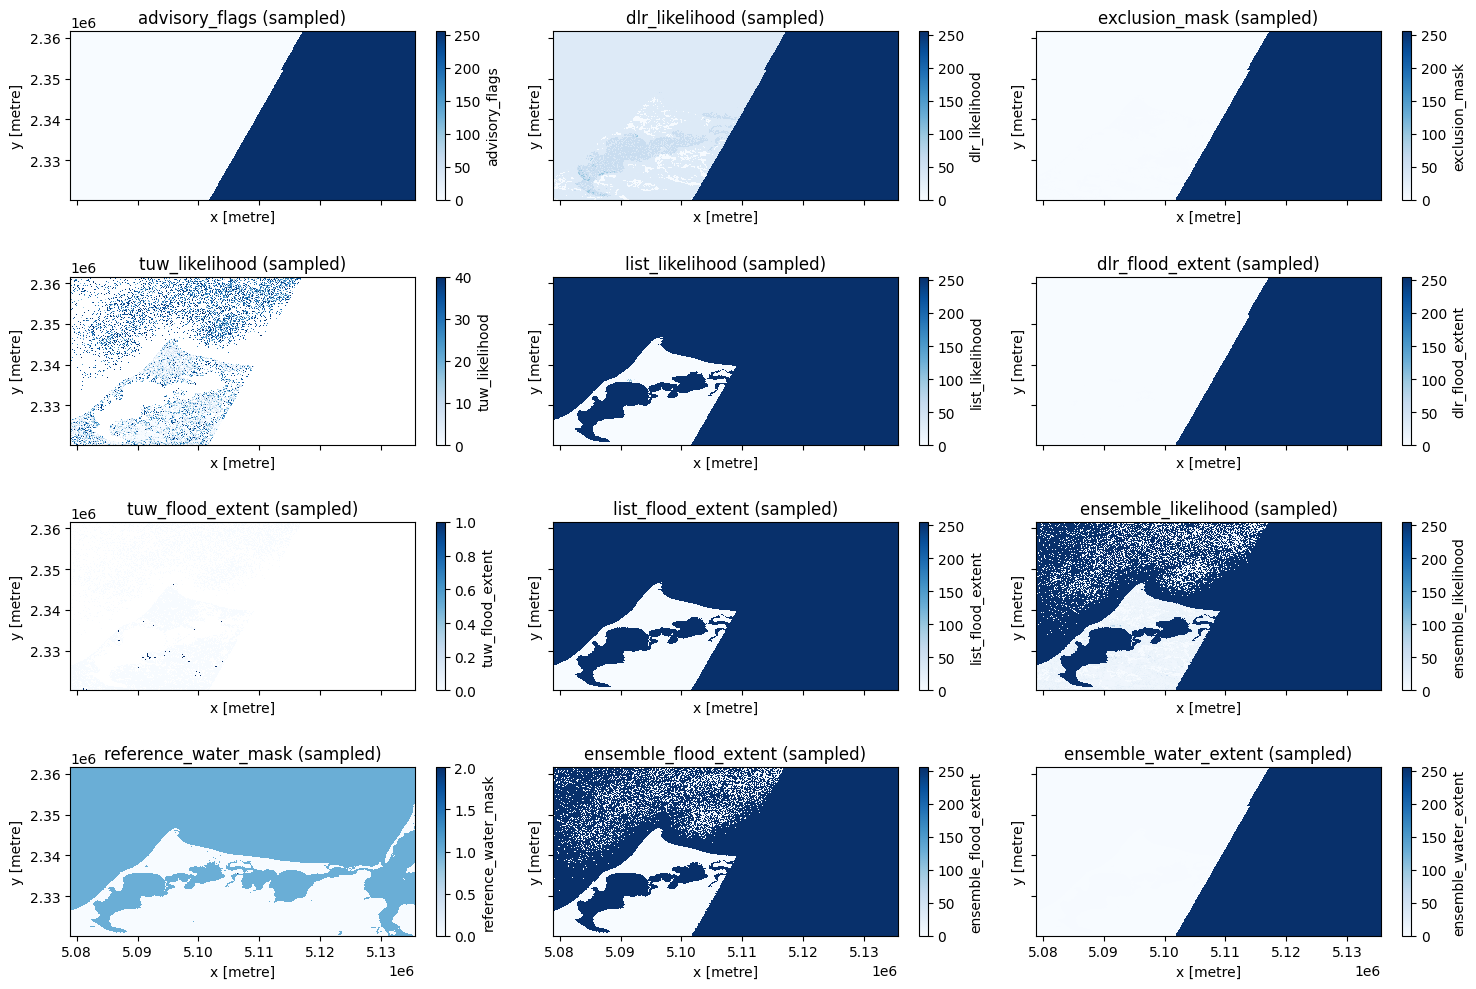

In [40]:
# Option 1: Sample every nth pixel for faster plotting
fig, ax = plt.subplots(4, 3, figsize=(15, 10), sharey=True, sharex=True)
band_names = list(german_dc.data_vars.keys())  # First 3 bands only

for i, band_name in enumerate(band_names):
    sampled_data = german_dc[band_name][0, ::4, ::4]
    col = i % 3
    row = i // 3
    sampled_data.plot(ax=ax[row, col], cmap='Blues')
    ax[row, col].set_title(f'{band_name} (sampled)')

plt.tight_layout()
plt.show()

In [41]:
german_tuw_flood_extent = german_dc["tuw_flood_extent"]

In [42]:
crs = german_tuw_flood_extent.rio.crs
ae_crs  =crs.to_proj4()
german_tuw_flood_extent = german_tuw_flood_extent.rio.write_crs(ae_crs)


#Reproject to WGS84 (lon/lat)
german_ll = german_tuw_flood_extent.rio.reproject("EPSG:4326")

#Clip to your bounding box
minlon, maxlon = 12.3, 13.1
minlat, maxlat = 54.3, 54.6
german_ll_clipped = german_ll.rio.clip_box(minx=minlon, maxx=maxlon, miny=minlat, maxy=maxlat)

In [43]:

german_visible =german_ll_clipped.where(german_ll_clipped == 1)

german_visible.hvplot.image(
    x="x", y="y",
    geo=True,
    tiles="OSM",
    cmap=["darkred"],
    alpha=0.75,
    frame_height=450,
    title="Flood Extent on Map",
    colorbar=False
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'1d1c1bac-4cf7-411a-82bf-1d7c38d4bd88': {'version…